In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import datetime
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
import pprint

from IPython.display import clear_output
from IPython.display import display

sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath("../pax"))

from pax_utils import event_utils
from pax_utils import file_utils
from pax_utils import interaction_utils
from pax_utils import s1s2_utils
from pax_utils import waveform_utils

from pax import core
from pax import dsputils

from pax.configuration import load_configuration

pp = pprint.PrettyPrinter(depth=2)



In [6]:

####################################################################################################
####################################################################################################

f = plt.figure(figsize=(30, 15))

def processPklEvents(zipfilename):

    ################################################################################################
    ################################################################################################
    
    lst_pkl_files  = file_utils.getListOfPklFilesFromZipFile(zipfilename, nEventsPerFile)

    
    ################################################################################################
    ################################################################################################
    
    intr0  = None
    sum_wf = None
    event  = None

    df_zip_merged = pd.DataFrame()
    
        
    ################################################################################################
    ################################################################################################
    
    for iPklFile in range(0, len(lst_pkl_files)):
    
        ############################################################################################
        ############################################################################################

        print("File: '" + str(zipfilename) + "'")
        print("   event_number: " + str(iPklFile))
        #clear_output(wait=True)
        
        
        ############################################################################################
        ############################################################################################

        jsonfilename = os.path.dirname(zipfilename) + '/pax_info.json'
        print("   CFG: '" + str(jsonfilename) + "'")
        
        cfg = event_utils.getConfig(jsonfilename)
        
        
        ############################################################################################
        ############################################################################################
        
        pklfilename  = lst_pkl_files[iPklFile]
        event        = file_utils.getPaxEventFromPklFileInZipArchive(zipfilename, pklfilename)

      
        ############################################################################################
        ############################################################################################
        
        interactions  = event.interactions
        nInteractions = len(interactions)
        
        if (nInteractions != 1): continue

            
        ############################################################################################
        ############################################################################################

        intr0 = None
        
        if (len(interactions) > 0):
            
            intr0 = interactions[0]
            
            
        ############################################################################################
        ############################################################################################
        
        df_pkl_event  = event_utils.getEventDataFrameFromEvent(event)
        df_pkl_intr   = interaction_utils.getInteractionDataFrameFromEvent(event)
        df_pkl_s2s    = s1s2_utils.getS2integralsDataFrame(event, 127)
        
     
        ############################################################################################
        ############################################################################################
    
        df_pkl_merged = df_pkl_event.merge(df_pkl_intr).merge(df_pkl_s2s)
        df_zip_merged = df_zip_merged.append(df_pkl_merged)
        
        #continue
      
    
         
        ############################################################################################
        # Summed Waveform from Event
        ############################################################################################
    
        summed_wafeform = waveform_utils.getSummedWaveformFromEvent(event)
        left            = event.main_s2.left
        right           = event.main_s2.right
        sum_intgr       = np.sum(summed_wafeform[left:right])
        corr            = intr0.s2_area_correction
        
        print(summed_wafeform.shape)
        
        f = plt.figure(figsize=(30, 15))
        plt.plot(summed_wafeform)
        plt.axvline(left , color='r', linestyle='dashed')
        plt.axvline(right, color='r', linestyle='dashed')
        plt.xlim(left - 10, right + 50)
        

        df  = df_pkl_s2s.drop(columns=['event_number'])
        arr = df.as_matrix()
        test = np.sum(arr, axis=1)
        
        #display(df[0:1][:])
        
        print("Summed Waveform Integral: " + str(sum_intgr))
        print("Sum of S2 Integrals:      " + str(test))
        
        
        ############################################################################################
        # Check Summed Waveforms
        ############################################################################################

        length = len(summed_wafeform)
        
        df_wfs     = waveform_utils.getS2waveformsAllChannels(event, cfg)
        arr_sum_wf = waveform_utils.getSummedWaveform(df_wfs)
        #arr_sum_wf = waveform_utils.getPaddedWaveform(arr_sum_wf, left, right, length)
        
       
        #arr_sum_wf = np.roll(arr_sum_wf, -45)

        #
        print(arr_sum_wf.shape)
        print("Sum Test:      " + str(np.sum(arr_sum_wf)))
        f=plt.figure(figsize=(30, 15))
        plt.plot(arr_sum_wf, color='r')

        
        ############################################################################################
        ############################################################################################
        
        arr_sum_wf2 = waveform_utils.Test(event, cfg)
        print(arr_sum_wf2.shape)
       
        f=plt.figure(figsize=(30, 15))
        plt.plot(arr_sum_wf, color='g')
        
        
        ############################################################################################
        ############################################################################################
          
        display(df_wfs[0:1][:])

        
        
        
        ############################################################################################
        ############################################################################################
    
        continue
            
    
    ################################################################################################
    ################################################################################################
    
    #plt.legend()
    
    df_zip_merged.reset_index(inplace=True, drop=True)
       
    return df_zip_merged, event, intr0, sum_wf

    

File: '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 0
   CFG: '../pax_run/pax_output/instructions_000000/pax_info.json'
File: '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
   event_number: 1
   CFG: '../pax_run/pax_output/instructions_000000/pax_info.json'
(148878,)
Summed Waveform Integral: 699.917
Sum of S2 Integrals:      [ 699.91725651]
(592,)
Sum Test:      690.827731839

HERE



,baseline,baseline_increase,channel,left,pulse,raw_data,right
0,-1.978723,-0.148936,0,105424,0,"[0.0280373777467, -0.000149932501319, 0.013943...",105523
1,-4.957447,0.255319,0,105690,1,"[0.0208406176834, -0.0284871752506, 0.00674696...",105791
2,-6.510638,1.489362,4,65458,2,"[-0.00214351710459, 0.0153774053155, -0.015284...",65559
3,-6.382979,0.829787,4,148292,3,"[0.00167753512533, 0.00605776573035, -0.007082...",148393
4,-5.127660,0.893617,5,10394,4,"[0.0246055143433, 0.0246055143433, 0.001004306...",10493



(148878,)


,channel,left,right,sum,raw_data
0,0,105380,105971,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


,event_number,event_n_pulses,event_pulses_count,intr_count,intr_x,intr_y,intr_x_nn,intr_y_nn,intr_xy_posrec_algorithm,intr_drift_time,...,s2_area_117,s2_area_118,s2_area_119,s2_area_120,s2_area_121,s2_area_122,s2_area_123,s2_area_124,s2_area_125,s2_area_126
0,1,400,400,1,3.117168,-16.583333,3.2708,-16.607226,PosRecTopPatternFit,400890.0,...,6.564991,0.0,0.400128,2.742959,3.460256,8.159419,38.424745,15.890681,1.354377,10.354574


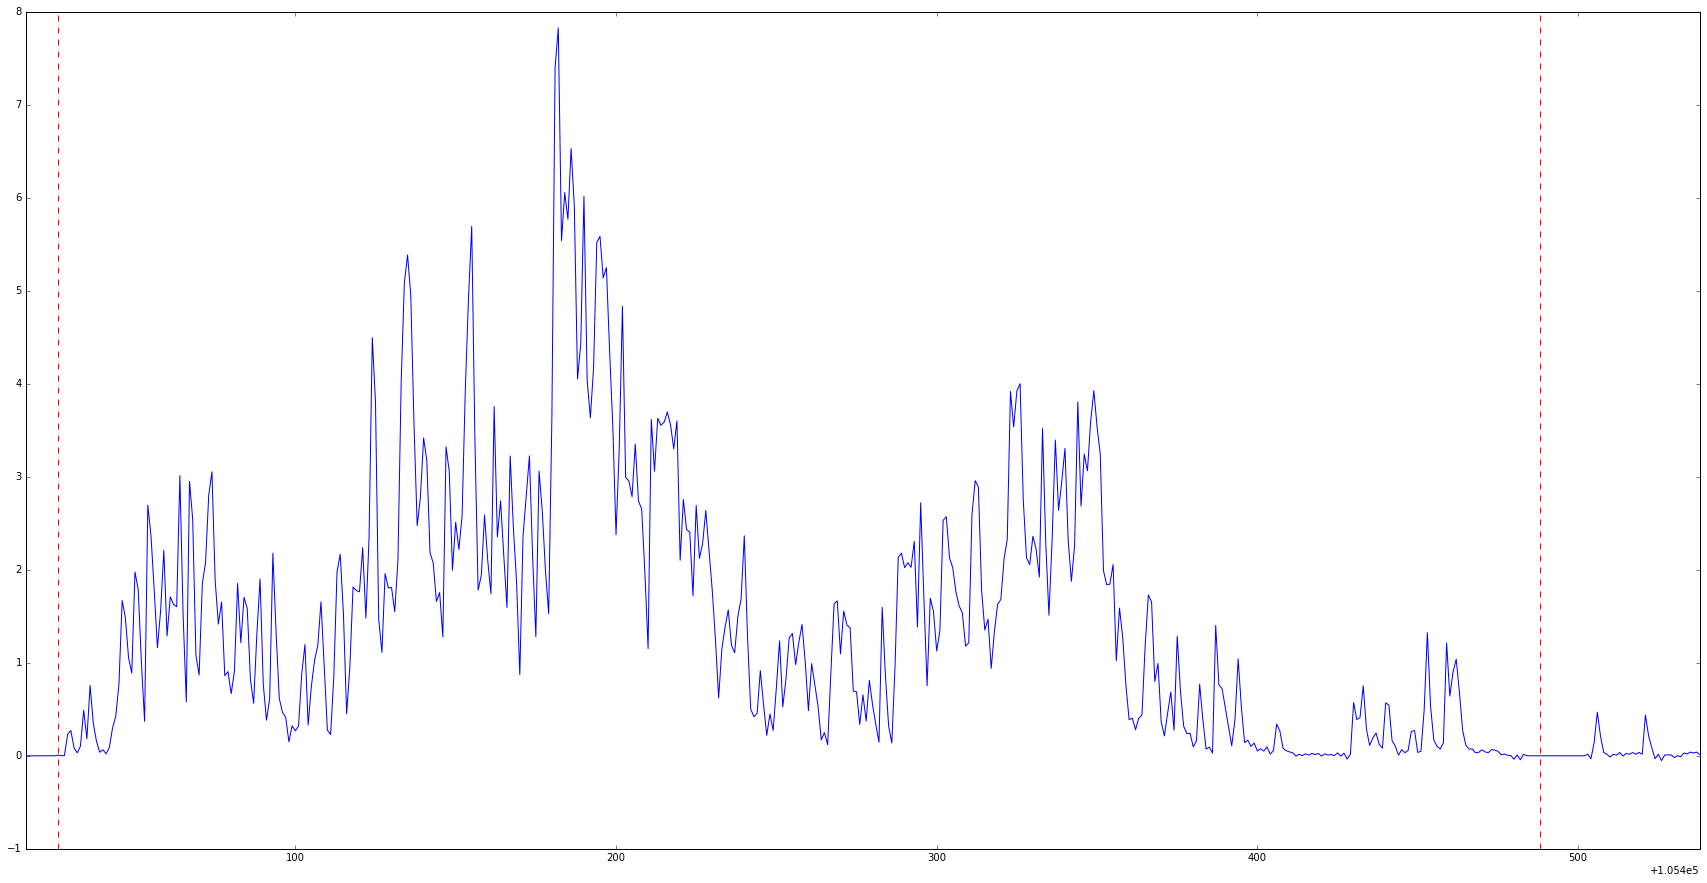

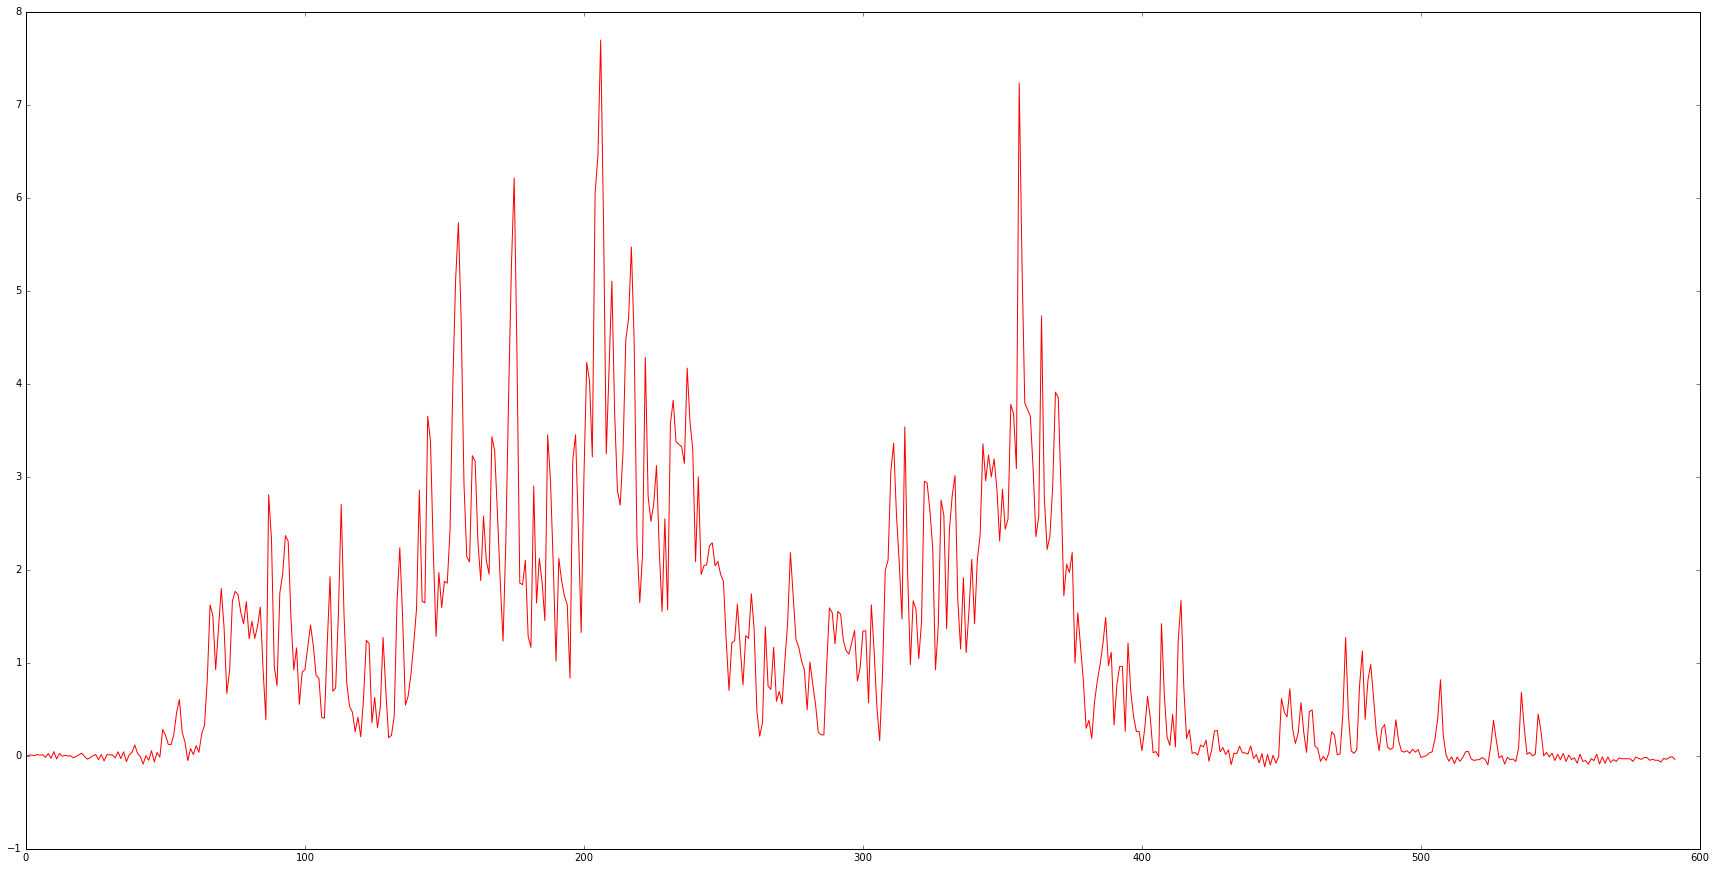

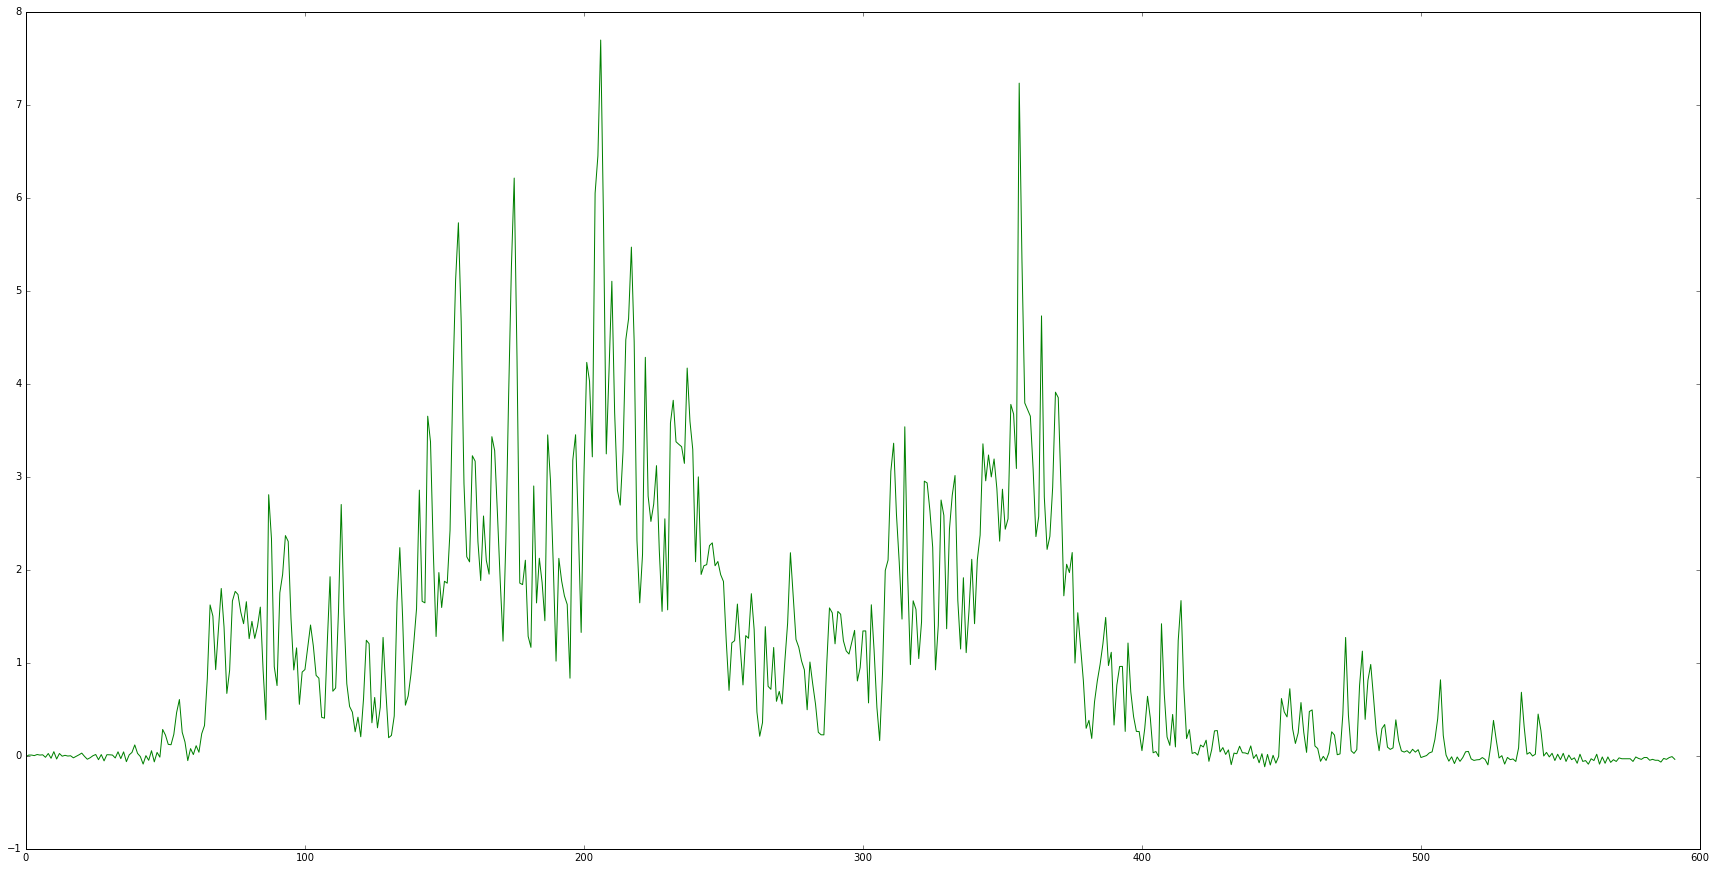

In [7]:

####################################################################################################
####################################################################################################

zipfilename    = '../pax_run/pax_output/instructions_000000/XENON1T-0-000000000-000000999-000001000.zip'
nEventsPerFile = 2


df_zip_merged, event, intr, wf_sum = processPklEvents(zipfilename)

#wfs = event.sum_waveforms

display(df_zip_merged)



    